# TRocr evaluation

emulated from: https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Evaluating_TrOCR_base_handwritten_on_the_IAM_test_set.ipynb?pli=1&authuser=1#scrollTo=Nkaki4CgZJNw

In [19]:
import pandas as pd
import numpy as np
import os

import torch
from torch.utils.data import Dataset
from PIL import Image

from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from torch.utils.data import DataLoader

from datasets import load_metric
from difflib import SequenceMatcher
import mlflow

Experiment parameters (log these to MLflow)

In [20]:
DATA_DIR = '/home/riikoro/fossil_data/tooth_samples'
DATA_VERSIONS = [1, 2]
MAX_TARGET_LENGTH = 64 
MODEL = 'microsoft/trocr-large-handwritten'
BATCH_SIZE = 2

In [21]:
dfs = []
for version in DATA_VERSIONS:
    df = pd.read_csv(os.path.join(DATA_DIR, f'v{version}', 'labels.tsv'), sep='\t')
    df['filename'] = f'v{version}/' + df['filename']
    dfs.append(df)
# label_dfs = [ for data_dir in data_dirs]
# label_dfs[0].head()
# TODO: read v2 labels
label_df = pd.concat(dfs, axis=0).reset_index()
label_df

,index,filename,text
0,0,v1/0.png,Distal half left humerus with broken medial
1,1,v1/1.png,Isolated
2,2,v1/2.png,"LI2̌, RM̱2̌ & tooth frags (8)"
3,3,v1/3.png,LM2̌
4,4,v1/4.png,right maxilla with frag of zygomatic and
...,...,...,...
94,27,v2/28.png,Px̄ frag.
95,28,v2/29.png,Prox. phalanx
96,29,v2/30.png,Edentulous md. (2 unassoc. elemen
97,30,v2/31.png,Prox. intermediate phal


In [22]:
print(label_df['text'][0])

Distal half left humerus with broken medial


In [23]:
class FossilDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['filename'][idx]
        text = self.df['text'][idx]

        # prepare image (i.e. resize + normalize)
        image = Image.open(os.path.join(self.root_dir, file_name)).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [24]:
processor = TrOCRProcessor.from_pretrained(MODEL)
test_dataset = FossilDataset(root_dir=DATA_DIR, df=label_df, processor=processor, max_target_length=MAX_TARGET_LENGTH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [25]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 384, 384])
labels torch.Size([2, 64])


In [26]:
labels = batch["labels"]
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.batch_decode(labels, skip_special_tokens=True)
label_str

['Distal half left humerus with broken medial', 'Isolated']

## Evaluate

In [10]:
device = 'cpu' # no gpu available

model = VisionEncoderDecoderModel.from_pretrained(MODEL)
model.to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=False)
              (key): Linear(in_features=1024, out_features=1024, bias=False)
              (value): Linear(in_features=1024, out_features=1024, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Line

In [34]:
cer = load_metric("cer")

In [74]:
from tqdm.notebook import tqdm

print("Running evaluation...")

predictions = []
for batch in tqdm(test_dataloader):
    # predict using generate
    pixel_values = batch["pixel_values"].to(device)
    outputs = model.generate(pixel_values, max_new_tokens=MAX_TARGET_LENGTH)

    # decode
    pred_str = processor.batch_decode(outputs, skip_special_tokens=True)
    print(pred_str)
    predictions.append(pred_str)
    labels = batch["labels"]
    labels[labels == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels, skip_special_tokens=True)
    print(label_str)

    # add batch to metric
    cer.add_batch(predictions=pred_str, references=label_str)

final_score = cer.compute()

Running evaluation...


  0%|          | 0/13 [00:00<?, ?it/s]

['Dustal half left numerous with broken medial', 'Isolated.', 'L2, # 1 tooth frags #', 'Litz', 'right maxilla with frag of zygomatic and', 'Isolated.', 'authorior.', 'memory.']
['Distal half left humerus with broken medial', 'Isolated', 'LI2̌, RM̱2̌ & tooth frags (8)', 'LM2̌', 'right maxilla with frag of zygomatic and', 'Isolated', 'anterior', 'man']
['Isolated RC, RP. RN.', 'Left mandible frog with broken Px, M, and', 'Isolated.', '93.', 'Snap. We Izalvedus, Crossot # (3-ME', 'Shalt lacking desstal A proximal ends', 'Frag left mandibular corpus lacking teeth', 'proximal frag. right ulna']
['Isolated RC̱, RP4̱̂, RM', 'Left mandible frag with broken P4̌, M1̌ and', 'Isolated', 'M3̂', 'frag wi I2̄̌ alveolus, croots P3̄̌-M2̄̌', 'Shaft lacking distal & proximal ends', 'Frag left mandibular corpus lacking teeth', 'proximal frag. right ulna']
['L mandible frag with roots M.s.', 'Aitupper premolas Uninterrupted. L.S. MDR', 'frag. right when proximal erd.wt shaft-', '10kote.', 'A :frey left man

In [75]:
def similarity(x, y):
    return SequenceMatcher(None, x, y).ratio()

def sequence_matcher_score(labels, predicted_labels):
    similarities = np.array([0.0] * len(labels))
    for i in range(len(labels)):
        similarities[i] = similarity(predicted_labels[i], labels[i])
    return np.mean(similarities)

predicted_labels = []
for pred_batch in predictions:
    predicted_labels.extend(pred_batch)

labels = list(label_df['text'])
print('correct:   ' + ', '.join(labels))
print('predicted: ' + ', '.join(predicted_labels))
print("Character error rate on test set:", final_score)
sequence_score = sequence_matcher_score(labels, predicted_labels)
print(f"Sequence matcher score, baseline: {sequence_score}")

correct:   Distal half left humerus with broken medial, Isolated, LI2̌, RM̱2̌ & tooth frags (8), LM2̌, right maxilla with frag of zygomatic and, Isolated, anterior, man, Isolated RC̱, RP4̱̂, RM, Left mandible frag with broken P4̌, M1̌ and, Isolated, M3̂, frag wi I2̄̌ alveolus, croots P3̄̌-M2̄̌, Shaft lacking distal & proximal ends, Frag left mandibular corpus lacking teeth, proximal frag. right ulna, L mandible frag with roots M2̌-̌3̌, A: 4 upper premolar (P3̱̌) unerrupted. L. mbs, frag. right ulna proximal erd. wt. shaft., lokote, A = frag left mandible corpus with M3̌ roots, M3̂, RT.mandible frag with P4̌-M2̌, Mandible lacking left ascending ramus;, Rt P4̄̌, LM1̂, Broken molar !(M̱), Isolated RM2̌, RM3̌, broken LM3̌, L mandible frag with M1̌-̌3̌, Proximal part right femur, A= R mandible with M2̄̌-̌3̄̌ M1̌ root, Left ulna lacking distal epiphysis, A = distal end left femur, Rt., proximal, Proximal & distal end right femur, Right humerus lacking prox. epiphysis, Left mandible frag with

## MLflow

In [76]:
%env MLFLOW_TRACKING_URI=sqlite:///mlruns.db
mlflow.set_experiment("Dental element OCR")

params = {
    'data_versions': DATA_VERSIONS,
    'max_new_tokens': MAX_TARGET_LENGTH,
    'model': MODEL,
    'batch_size': BATCH_SIZE
}

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("sequence matcher score", sequence_score)
    mlflow.log_metric('cer', final_score)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("info", "Untuned TrOCR-handwritten-large, emulated from https://github.com/NielsRogge/Transformers-Tutorials, added v2 data")

env: MLFLOW_TRACKING_URI=sqlite:///mlruns.db


# Fine-tune

work in progress... from https://github.com/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_native_PyTorch.ipynb

In [27]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(label_df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [28]:
train_dataset = FossilDataset(root_dir=DATA_DIR, df=train_df, processor=processor, max_target_length=MAX_TARGET_LENGTH)
eval_dataset = FossilDataset(root_dir=DATA_DIR, df=test_df, processor=processor, max_target_length=MAX_TARGET_LENGTH)
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 79
Number of validation examples: 20


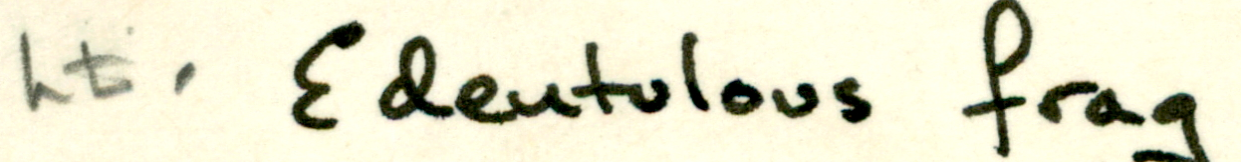

In [29]:
image = Image.open(train_dataset.root_dir +'/' + train_df['filename'][0]).convert("RGB")
image

In [30]:
encoding = train_dataset[0]
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

Lt. Edentulous frag


In [31]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE)

In [32]:
# not changed from tutorial, TODO: figure out vocabulary
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [33]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(1):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    
   # evaluate
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(eval_dataloader):
       # run batch generation
       outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer 

   print("Validation CER:", valid_cer / len(eval_dataloader))

model.save_pretrained(".")

/home/riikoro/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/40 [00:00<?, ?it/s]

Loss after epoch 0: 4.187830087542534


  0%|          | 0/10 [00:00<?, ?it/s]

/home/riikoro/anaconda3/lib/python3.11/site-packages/transformers/generation/utils.py:1417: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


NameError: name 'compute_cer' is not defined

In [35]:

   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(eval_dataloader):
       # run batch generation
       outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer 

   print("Validation CER:", valid_cer / len(eval_dataloader))

  0%|          | 0/10 [00:00<?, ?it/s]

NameError: name 'compute_cer' is not defined